<a href="https://colab.research.google.com/github/AnIsAsPe/Estadistica_y_Probabilidad_para-CD-/blob/main/PrincipiosDeProbabilidad/Semana6/Metropolis_Hastings_para_decifrar_textos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Algoritmo Metropolis Hastings para decifrar textos <h2>

El presente código es una adaptación del presentado en [este repositorio](https://github.com/svivek/mcmc-decoding-example)

El ejemplo está inspirado en la historia descrita en [The Markov Chain Monte Carlo Revolution](https://www.ams.org/journals/bull/2009-46-02/S0273-0979-08-01238-X/S0273-0979-08-01238-X.pdf).







<img src='https://pbs.twimg.com/media/DnJnUCpWwAAmPnR.jpg'>



El objetivo es decifrar los mensajes intercambiados por prisioneros, con la conjetura de que cada simbolo representa una letra o simbolo del lenguaje. La tarea es pues, encontrar ese diccionario o **clave** para codificar y decodificar los mensajes.

# Bibliotecas y Funciones

In [34]:
import re
from collections import Counter
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [35]:
def limpiar_texto(texto):

    #cambiar texto a minusculas
    texto = texto.lower()

    # quitar tildes
    a,b = 'áéíóúü','aeiouu'
    trans = str.maketrans( a,b)
    texto = texto.translate(trans)

    # solo letras y numeros
    texto = re.sub('[^ña-z0-9 ]+' ,' ', texto).strip()

    # remplazar multiples espacios contiguos por un solo espacio
    texto = re.sub('\s+',' ', texto)
    return texto

def find_between( s, first, last ):
    '''fuente: https://stackoverflow.com/questions/3368969/find-string-between-two-substrings'''
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""
def leer_texto(file, inicio=None, fin=None):
    with open(file, 'r') as f:
        if inicio is not None and fin is not None:
            libro = find_between(f.read(), inicio, fin)
        else:
            libro = f.read()
    return limpiar_texto(libro)

In [3]:
def bigram_log_probabilities(book):

    character_counts = Counter(book)
    bigram_counts = Counter(zip(book, book[1:]))
    bigrams = bigram_counts.keys()
    return dict(map(lambda k: [k, math.log(bigram_counts[k]) - math.log(character_counts[k[0]])], bigrams))

In [4]:
LOG_EPSILON = -30  # probabilidad muy pequeña vista como logaritmo, que se usará
                   # cuando no exista probabilidad de transición de una letra a otra

def goodness(text, bigram_table):
    bigrams = zip(text, text[1:])
    sum = 0
    for b in bigrams:
        sum += bigram_table.get(b) or LOG_EPSILON
    return sum

In [36]:
def MatrizTransisionLetras(book):

    character_counts = Counter(book)
    bigram_counts = Counter(zip(book, book[1:]))
    bigrams = bigram_counts.keys()
    MT = pd.DataFrame(LOG_EPSILON,
                      index = [ch for ch in alphabet],
                      columns =  [ch for ch in alphabet],
                      dtype=float)
    for row, col in bigrams:
        MT.loc[row, col] = math.log(bigram_counts[(row, col)]) - math.log(character_counts[row])

    fig = plt.figure(figsize = (25, 20))
    ax = sns.heatmap(np.exp(MT),
                     cmap = "mako_r",
                     cbar = False,
                     annot = True,
                     fmt=".2f",
                     square = True)
    ax.xaxis.tick_top()
    plt.show()

## Cifrado por sustitución

Es un método de cifrado para codificar y decodificar mensajes usando una clave que relaciona una letra o simbolo por otro.

Como ejemplo, se puede suponer que la clave de un cifrado está contenida en la siguiente tabla:

|original | codificado |
|---------|------------|
|a        | z          |
|n        | 4          |
|l        | 5          |
|i        | a          |
|s        | 8          |

De manera que la palabra  `analisis` puede ser codificada como `z4z5a8a8`.

In [6]:
def code(text, key):
    return ''.join(list(map(lambda char: key[char], text)))

In [7]:
clave = {'a': 'z', 'n': '4', 'l': '5', 'i': 'a', 's':'8'}
code('analisis', clave)

'z4z5a8a8'

Y podemos decodificar la palabra usando la clave inversa:

In [8]:
inv_clave = {v : k for k, v in clave.items()}
code('z4z5a8a8', inv_clave)

'analisis'

#¿Cómo encontrar una clave adecuada?

Si consideramos solamente el espacio en blanco, las letras en minúscula, y los números estamos hablando de 38 simbolos, y por tanto el espacio muestral en el que vive la clave es enorme.

In [9]:
alphabet = "abcdefghijklmnñopqrstuvwxyz0123456789 "

print('Total de simbolos considerados:', len(alphabet))

from math import factorial
print('Tamaño del espacio muestral en el que vive la clave que buscamos', factorial(38))

Total de simbolos considerados: 38
Tamaño del espacio muestral en el que vive la clave que buscamos 523022617466601111760007224100074291200000000


Supondremos que el lenguaje de los mensajes cifrados es el español, por tanto utilizaremos como guía las probabilidades de transición de los carácteres en español.

# ¿Cómo obtener la matriz de transición de los caracteres?


Para aprender estas probabilidades usaremos un texto, lo más largo posible en español

Se puede calcular las probabilidades de transisión utilizando cualquier texto. Si este es suficientemente grande, podremos obtener buenas estimaciones. Usaremos Don Quijote de la Mancha, que tiene más de 2 millones de caracteres.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
inicio = "*** START OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***"
fin = "*** END OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***"

file = '/content/drive/MyDrive/Datos/DonQuijote.txt'
DonQ = leer_texto(file, inicio, fin )

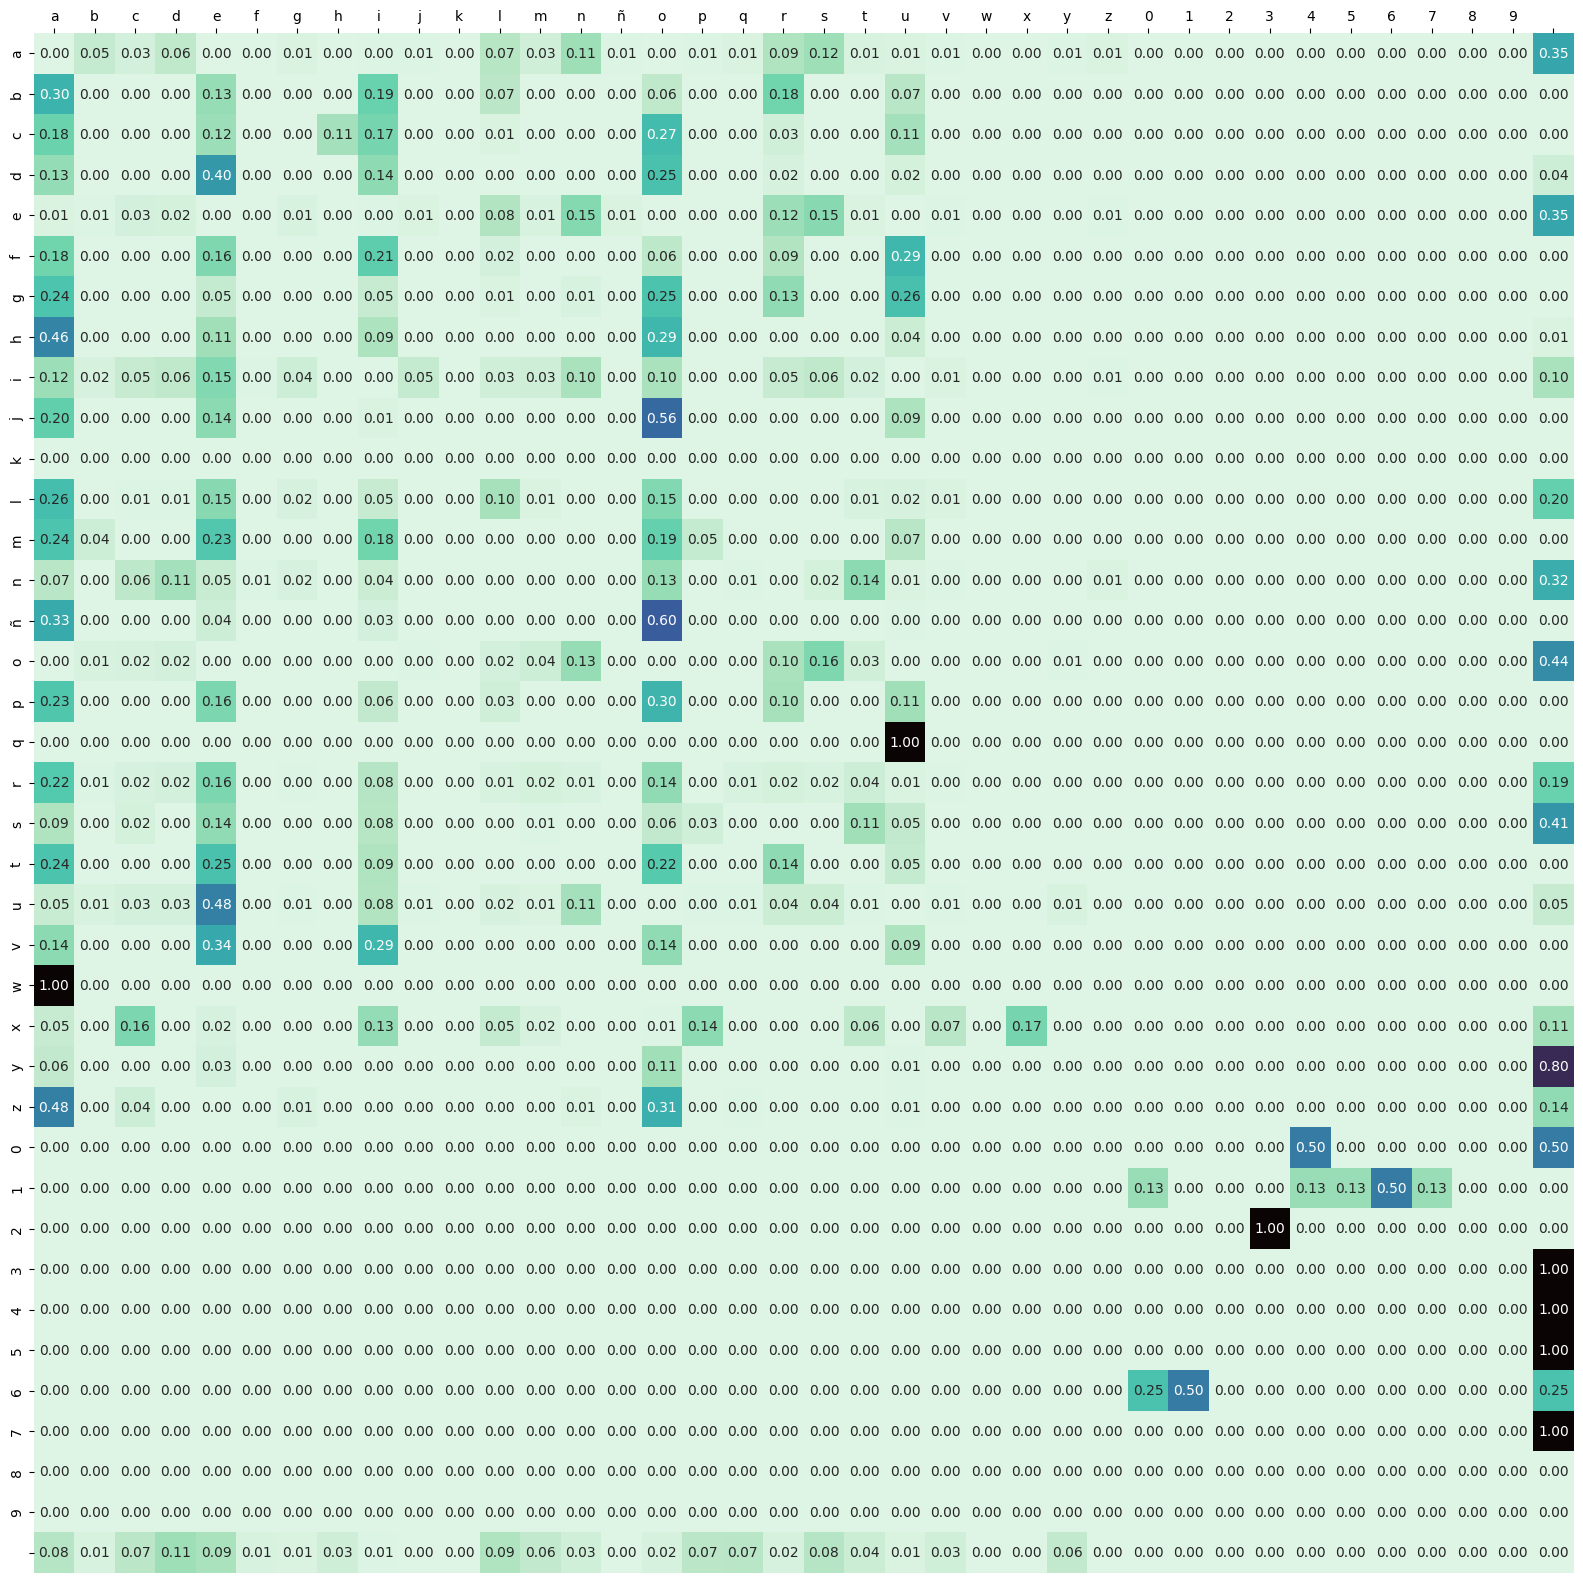

In [37]:
 MatrizTransisionLetras(DonQ)

In [13]:
bigram_table = bigram_log_probabilities(DonQ)
bigram_table

{('e', 'l'): -2.495635370118805,
 ('l', ' '): -1.633573260510028,
 (' ', 'i'): -4.937384512589171,
 ('i', 'n'): -2.3504318062150116,
 ('n', 'g'): -4.031173508631302,
 ('g', 'e'): -2.980174879019078,
 ('e', 'n'): -1.8827851415801167,
 ('n', 'i'): -3.196628842521836,
 ('i', 'o'): -2.349621480303913,
 ('o', 's'): -1.8348327937786753,
 ('s', 'o'): -2.8913442783423715,
 ('o', ' '): -0.8242763995237041,
 (' ', 'h'): -3.420071451532097,
 ('h', 'i'): -2.3957986266629003,
 ('i', 'd'): -2.801143855311272,
 ('d', 'a'): -2.023135023232147,
 ('a', 'l'): -2.6003410610565005,
 ('l', 'g'): -4.105093437001927,
 ('g', 'o'): -1.4025662217672572,
 (' ', 'd'): -2.166409555430894,
 ('d', 'o'): -1.3743360383401892,
 ('o', 'n'): -2.0723476075124374,
 ('n', ' '): -1.137340896369082,
 (' ', 'q'): -2.633056752874694,
 ('q', 'u'): 0.0,
 ('u', 'i'): -2.480561604574996,
 ('i', 'j'): -2.933481589751146,
 ('j', 'o'): -0.5809899206883387,
 ('o', 't'): -3.485054422488467,
 ('t', 'e'): -1.3776567950215597,
 ('e', ' '): 

# Calificación de las claves candidatas

Para cada secuencia de caracteres $c_1c_2c_3\cdots c_n$, estimaresmos su probabilidad de la siguiente manera

$$P(c_1c_2c_3\cdots c_n) = P(c_1) P(c_2 \mid c_1) P(c_3 \mid c_2) \cdots P(c_n \mid c_{n-1})$$

Así, la probabilidad de la palabra `analisis` se calcularía como

 $P(a)~P(n \mid a)P(a \mid n)P(l \mid a)P(i \mid l)P(s \mid i)P(i \mid s)P(s \mid i)$.

Para hacer lo anterior necesitamos una matriz de transición de un caracter a otro, y en este sentido, para facilitar el análisis,  ignoraremos el primer caracter porque no hará practicamente diferencia en una secuencia larga.

Mediante la función "goodness", valiendonos de las probabilidades de la matriz de transisión de caracteres en español,  compararemos las secuencias decodificadas para ver con cual clave se produce una secuencia más plausible.

In [14]:
print("Log probability of 'opamc' = ",goodness("opamc", bigram_table))

Log probability of 'opamc' =  -40.784560457172915


In [15]:
print("Log probabilidad de 'campo' = " +str(goodness("campo", bigram_table)))

Log probabilidad de 'campo' = -9.40201613643682


# Implementación

## Creación del mensaje encriptado

In [16]:
plain_text = limpiar_texto(
    """Muchos años después, frente al pelotón de fusilamiento, el coronel Aureliano Buendía había de
recordar aquella tarde remota en que su padre lo llevó a conocer el hielo. Macondo era entonces
una aldea de veinte casas de barro y cañabrava construidas a la orilla de un río de aguas diáfanas
que se precipitaban por un lecho de piedras pulidas, blancas y enormes como huevos
prehistóricos. El mundo era tan reciente, que muchas cosas carecían de nombre, y para
mencionarlas había que señalarías con el dedo. Todos los años, por el mes de marzo, una familia
de gitanos desarrapados plantaba su carpa cerca de la aldea, y con un grande alboroto de pitos y
timbales daban a conocer los nuevos inventos. Primero llevaron el imán. Un gitano corpulento, de
barba montaraz y manos de gorrión, que se presentó con el nombre de Melquíades, hizo una
truculenta demostración pública de lo que él mismo llamaba la octava maravilla de los sabios
alquimistas de Macedonia. Fue de casa en casa arrastrando dos lingotes metálicos, y todo el
mundo se espantó al ver que los calderos, las pailas, las tenazas y los anafes se caían de su sitio,
y las maderas crujían por la desesperación de los clavos y los tornillos tratando de desenclavarse,
y aun los objetos perdidos desde hacía mucho tiempo aparecían por donde más se les había
buscado, y se arrastraban en desbandada turbulenta detrás de los fierros mágicos de Melquíades.
"""
)

In [17]:
import random

def make_random_key():
    l = list(alphabet)
    random.shuffle(l)
    return dict(zip(alphabet, l))

In [18]:
key = make_random_key()
cipher_text = code(plain_text, key)
cipher_text

'6v5lcu74qcu7heufveu7treoie74p7fepcico7he7tvudp46deoic7ep75crcoep74vrepd4oc7zveohd47l4zd47he7re5crh4r742vepp47i4rhe7re6ci47eo72ve7uv7f4hre7pc7ppe1c7475coc5er7ep7ldepc7645cohc7er47eoico5eu7vo474phe47he71edoie754u4u7he7z4rrc7a754q4zr41475couirvdh4u747p47crdpp47he7vo7rdc7he743v4u7hd4t4o4u72ve7ue7fre5dfdi4z4o7fcr7vo7pe5lc7he7fdehr4u7fvpdh4u7zp4o54u7a7eocr6eu75c6c7lve1cu7frelduicrd5cu7ep76vohc7er47i4o7re5deoie72ve76v5l4u75cu4u754re5d4o7he7oc6zre7a7f4r476eo5dco4rp4u7l4zd472ve7ueq4p4rd4u75co7ep7hehc7ichcu7pcu74qcu7fcr7ep76eu7he764rbc7vo47t46dpd47he73di4ocu7heu4rr4f4hcu7fp4oi4z47uv754rf475er547he7p474phe47a75co7vo73r4ohe74pzcrcic7he7fdicu7a7id6z4peu7h4z4o7475coc5er7pcu7ove1cu7do1eoicu7frd6erc7ppe14rco7ep7d64o7vo73di4oc75crfvpeoic7he7z4rz476coi4r4b7a764ocu7he73crrdco72ve7ue7freueoic75co7ep7oc6zre7he76ep2vd4heu7ldbc7vo47irv5vpeoi47he6cuir45dco7fvzpd547he7pc72ve7ep76du6c7pp464z47p47c5i414764r41dpp47he7pcu7u4zdcu74p2vd6dui4u7he7645ehcod47tve7he754u47eo754u474rr4uir4ohc7hcu7pdo3cieu76ei4pd5cu7a7ich

## Busqueda de la clave

Empezaremos la busqueda de la clave adecuado, utilizando en el inicio una **clave** aleatoria que iremos cambiando por una  clave cercana, simplemente transponiendo dos caracteres seleccionados aleatoriamente.

In [19]:
clave0 = make_random_key()  # creamos una clave inicial
clave0

{'a': 'k',
 'b': 'y',
 'c': 'h',
 'd': 't',
 'e': 's',
 'f': 'r',
 'g': '1',
 'h': 'g',
 'i': 'm',
 'j': 'q',
 'k': 'l',
 'l': 'o',
 'm': 'd',
 'n': '3',
 'ñ': 'z',
 'o': '9',
 'p': '8',
 'q': '0',
 'r': 'e',
 's': 'p',
 't': 'j',
 'u': 'u',
 'v': 'c',
 'w': 'v',
 'x': '4',
 'y': '5',
 'z': '6',
 '0': 'w',
 '1': 'ñ',
 '2': 'f',
 '3': '7',
 '4': 'i',
 '5': ' ',
 '6': '2',
 '7': 'x',
 '8': 'a',
 '9': 'b',
 ' ': 'n'}

In [20]:
decoded0 =code(cipher_text, clave0) # decodificamos
decoded0

'2c ohuxi0huxgsurcsuxjes9msxi8xrs8hmh9xgsxjcut8i2ts9mhxs8x heh9s8xices8ti9hx6cs9gtixoi6tixgsxes hegiexifcs88ixmiegsxes2hmixs9xfcsxucxrigesx8hx88sñhxix h9h sexs8xots8hx2i h9ghxseixs9mh9 suxc9ixi8gsixgsxñst9msx iuiuxgsx6ieehxkx i0i6eiñix h9umectgiuxix8ixhet88ixgsxc9xethxgsxi7ciuxgtiji9iuxfcsxusxres trtmi6i9xrhexc9x8s ohxgsxrtsgeiuxrc8tgiux68i9 iuxkxs9he2sux h2hxocsñhuxresotumhet huxs8x2c9ghxseixmi9xes ts9msxfcsx2c oiux huiux ies ti9xgsx9h26esxkxrieix2s9 th9ie8iuxoi6tixfcsxus0i8ietiux h9xs8xgsghxmhghux8huxi0huxrhexs8x2suxgsx2ieyhxc9ixji2t8tixgsx7tmi9huxgsuieeirighuxr8i9mi6ixucx ierix se ixgsx8ixi8gsixkx h9xc9x7ei9gsxi86hehmhxgsxrtmhuxkxmt26i8suxgi6i9xix h9h sex8hux9csñhuxt9ñs9mhuxret2sehx88sñieh9xs8xt2i9xc9x7tmi9hx herc8s9mhxgsx6ie6ix2h9mieiyxkx2i9huxgsx7heeth9xfcsxusxresus9mhx h9xs8x9h26esxgsx2s8fctigsuxotyhxc9ixmec c8s9mixgs2humei th9xrc68t ixgsx8hxfcsxs8x2tu2hx88i2i6ix8ixh miñix2ieiñt88ixgsx8huxui6thuxi8fct2tumiuxgsx2i sgh9tixjcsxgsx iuixs9x iuixieeiumei9ghxghux8t97hmsux2smi8t huxkxmhg

In [21]:
log_p0 = goodness(decoded0, bigram_table)  # evaluamos
log_p0

-26283.071825577994

In [22]:
pair = random.sample(alphabet, 2)
pair[0], pair[1]

('p', 'm')

In [23]:
clave0[pair[0]] , clave0[pair[1]]

('8', 'd')

In [24]:
clave1 = clave0.copy()
clave1[pair[0]] = clave0[pair[1]]
clave1[pair[1]] = clave0[pair[0]]
clave1

{'a': 'k',
 'b': 'y',
 'c': 'h',
 'd': 't',
 'e': 's',
 'f': 'r',
 'g': '1',
 'h': 'g',
 'i': 'm',
 'j': 'q',
 'k': 'l',
 'l': 'o',
 'm': '8',
 'n': '3',
 'ñ': 'z',
 'o': '9',
 'p': 'd',
 'q': '0',
 'r': 'e',
 's': 'p',
 't': 'j',
 'u': 'u',
 'v': 'c',
 'w': 'v',
 'x': '4',
 'y': '5',
 'z': '6',
 '0': 'w',
 '1': 'ñ',
 '2': 'f',
 '3': '7',
 '4': 'i',
 '5': ' ',
 '6': '2',
 '7': 'x',
 '8': 'a',
 '9': 'b',
 ' ': 'n'}

In [25]:
decoded1 =code(cipher_text, clave1) # decodificamos
decoded1

'2c ohuxi0huxgsurcsuxjes9msxidxrsdhmh9xgsxjcutdi2ts9mhxsdx heh9sdxicesdti9hx6cs9gtixoi6tixgsxes hegiexifcsddixmiegsxes2hmixs9xfcsxucxrigesxdhxddsñhxix h9h sexsdxotsdhx2i h9ghxseixs9mh9 suxc9ixidgsixgsxñst9msx iuiuxgsx6ieehxkx i0i6eiñix h9umectgiuxixdixhetddixgsxc9xethxgsxi7ciuxgtiji9iuxfcsxusxres trtmi6i9xrhexc9xds ohxgsxrtsgeiuxrcdtgiux6di9 iuxkxs9he2sux h2hxocsñhuxresotumhet huxsdx2c9ghxseixmi9xes ts9msxfcsx2c oiux huiux ies ti9xgsx9h26esxkxrieix2s9 th9iediuxoi6tixfcsxus0idietiux h9xsdxgsghxmhghuxdhuxi0huxrhexsdx2suxgsx2ieyhxc9ixji2tdtixgsx7tmi9huxgsuieeirighuxrdi9mi6ixucx ierix se ixgsxdixidgsixkx h9xc9x7ei9gsxid6hehmhxgsxrtmhuxkxmt26idsuxgi6i9xix h9h sexdhux9csñhuxt9ñs9mhuxret2sehxddsñieh9xsdxt2i9xc9x7tmi9hx hercds9mhxgsx6ie6ix2h9mieiyxkx2i9huxgsx7heeth9xfcsxusxresus9mhx h9xsdx9h26esxgsx2sdfctigsuxotyhxc9ixmec cds9mixgs2humei th9xrc6dt ixgsxdhxfcsxsdx2tu2hxddi2i6ixdixh miñix2ieiñtddixgsxdhuxui6thuxidfct2tumiuxgsx2i sgh9tixjcsxgsx iuixs9x iuixieeiumei9ghxghuxdt97hmsux2smidt huxkxmhg

In [26]:
log_p1 = goodness(decoded1, bigram_table)  # evaluamos
log_p1

-24572.79057671648

En base a lo anterior ¿Aceptamos la nueva clave propuesta?

## Algoritmo completo

In [27]:
def transpose_random(key):
    pair = random.sample(alphabet, 2)
    new_key = dict(key)
    new_key[pair[0]] = key[pair[1]]
    new_key[pair[1]] = key[pair[0]]
    return new_key

def decode(cipher_text, bigram_table, iters = 10000, print_every = 1000):
    # 1. inicializamos con una clave aleatoria
    current_key = make_random_key()

    for i in range(0, iters):  # en cada iteración utilizaremos una nueva clave

        # 2. decodificamos la secuencia con la clave
        decoded = code(cipher_text, current_key)

        if i % print_every == 0:
            print(str(i) + "\t" + decoded + "\n")

        # 3. evaluamos la secuencia utilizando el modelo de bigramas
        score = goodness(decoded, bigram_table)

        # 4. proponemos una nueva clave "cercana"
        changed_key = transpose_random(current_key)

        # 5. evaluamos la nueva clave decodificando la secuencia
        changed_score = goodness(code(cipher_text, changed_key), bigram_table)  # evaluamos la secuencia con la nueva clave propuesta

        # 6.1 si la clave propuesta da mejores resultados nos quedamos con ella para la prox iteración
        if changed_score > score:
            current_key = changed_key

        # damos oportunidad proporcional a la relación entre la probabilidad de las dos secuencias evaluadas
        else:
            diff = changed_score - score
            if math.log(random.random())  < diff:
                current_key = changed_key

    decoded = code(cipher_text, current_key)
    print("Final decoded: " + decoded)
    return decoded

In [28]:
decode(cipher_text, bigram_table, 10000)

0	iw auhorguhoxñhmwñhonkñ2cñor0omñ0ucu2oxñonwhj0rijñ2cuoñ0o uku2ñ0orwkñ0jr2uofwñ2xjroarfjroxñokñ ukxrkorvwñ00rocrkxñokñiucroñ2ovwñohwomrxkño0uo00ñ5uoro u2u ñkoñ0oajñ0uoir u2xuoñkroñ2cu2 ñhow2ror0xñroxño5ñj2cño rhrhoxñofrkkuo1o rgrfkr5ro u2hckwjxrhoro0roukj00roxñow2okjuoxñorywrhoxjrnr2rhovwñohñomkñ jmjcrfr2omukow2o0ñ auoxñomjñxkrhomw0jxrhof0r2 rho1oñ2ukiñho uiuoawñ5uhomkñajhcukj uhoñ0oiw2xuoñkrocr2okñ jñ2cñovwñoiw arho uhrho rkñ jr2oxño2uifkño1omrkroiñ2 ju2rk0rhoarfjrovwñohñgr0rkjrho u2oñ0oxñxuocuxuho0uhorguhomukoñ0oiñhoxñoirkduow2ronrij0jroxñoyjcr2uhoxñhrkkrmrxuhom0r2crfrohwo rkmro ñk roxño0ror0xñro1o u2ow2oykr2xñor0fukucuoxñomjcuho1ocjifr0ñhoxrfr2oro u2u ñko0uho2wñ5uhoj25ñ2cuhomkjiñkuo00ñ5rku2oñ0ojir2ow2oyjcr2uo ukmw0ñ2cuoxñofrkfroiu2crkrdo1oir2uhoxñoyukkju2ovwñohñomkñhñ2cuo u2oñ0o2uifkñoxñoiñ0vwjrxñhoajduow2rockw w0ñ2croxñiuhckr ju2omwf0j roxño0uovwñoñ0oijhiuo00rirfro0rou cr5roirkr5j00roxño0uhohrfjuhor0vwjijhcrhoxñoir ñxu2jronwñoxño rhroñ2o rhrorkkrhckr2xuoxuho0j2yucñhoiñcr0j uho1ocu

'muchos años despues frente al peloton de fusilamiento el coronel aureliano buendia habia de recordar avuella tarde remota en vue su padre lo llejo a conocer el hielo macondo era entonces una aldea de jeinte casas de barro y cañabraja construidas a la orilla de un rio de aguas diafanas vue se precipitaban por un lecho de piedras pulidas blancas y enormes como huejos prehistoricos el mundo era tan reciente vue muchas cosas carecian de nombre y para mencionarlas habia vue señalarias con el dedo todos los años por el mes de marzo una familia de gitanos desarrapados plantaba su carpa cerca de la aldea y con un grande alboroto de pitos y timbales daban a conocer los nuejos injentos primero llejaron el iman un gitano corpulento de barba montaraz y manos de gorrion vue se presento con el nombre de melvuiades hizo una truculenta demostracion publica de lo vue el mismo llamaba la octaja marajilla de los sabios alvuimistas de macedonia fue de casa en casa arrastrando dos lingotes metalicos y tod

# Otros ejemplos

In [29]:
# El principito. Tomado de https://archive.org/stream/ElPrincipitoAntoineDeSaintExupery/El_principito-_Antoine_De_Saint_Exupery_djvu.txt

plain_text = limpiar_texto(
    """Tengo poderosas razones para creer que el planeta del cual venía el principito era
el asteroide B 612. Este asteroide ha sido visto sólo una vez con el telescopio en
1909, por un astrónomo turco.
Este astrónomo hizo una gran demostración de su descubrimiento en un congreso
Internacional de Astronomía. Pero nadie le creyó a causa de su manera de vestir.
Las personas mayores son así. Felizmente para la reputación del asteroide B 612,
un dictador turco impuso a su pueblo, bajo pena de muerte, el vestido a la
europea. Entonces el astrónomo volvió a dar cuenta de su descubrimiento en 1920
y como lucía un traje muy elegante, todo el mundo aceptó su demostración.
"""
)
cipher_text = code(plain_text, key)
cipher_text

'ieo3c7fchercu4u7r4bcoeu7f4r475reer72ve7ep7fp4oei47hep75v4p71eod47ep7frdo5dfdic7er47ep74uiercdhe7z78ñy7euie74uiercdhe7l47udhc71duic7ucpc7vo471eb75co7ep7iepeu5cfdc7eo7ñjwj7fcr7vo74uircoc6c7ivr5c7euie74uircoc6c7ldbc7vo473r4o7he6cuir45dco7he7uv7heu5vzrd6deoic7eo7vo75co3reuc7doiero45dco4p7he74uircoc6d47ferc7o4hde7pe75reac74754vu47he7uv764oer47he71euidr7p4u7feruco4u764acreu7uco74ud7tepdb6eoie7f4r47p47refvi45dco7hep74uiercdhe7z78ñy7vo7hd5i4hcr7ivr5c7d6fvuc747uv7fvezpc7z4mc7feo47he76verie7ep71euidhc747p47evrcfe47eoico5eu7ep74uircoc6c71cp1dc747h4r75veoi47he7uv7heu5vzrd6deoic7eo7ñjyw7a75c6c7pv5d47vo7ir4me76va7epe34oie7ichc7ep76vohc745efic7uv7he6cuir45dco'

In [30]:
decode(cipher_text, bigram_table, 20000)

0	87 139e3i7x3fkf9xkt3 7f9ekxk9jx77x95r797g9egk 78k9i7g9jrkg9o7 yk97g9exy jyey8397xk97g9kf87x3yi79m9vpw97f879kf87x3yi794k9fyi39oyf839f3g39r k9o7t9j3 97g987g7fj3ey397 9pbsb9e3x9r 9kf8x3 3u398rxj397f879kf8x3 3u394yt39r k91xk 9i7u3f8xkjy3 9i79fr9i7fjrmxyuy7 8397 9r 9j3 1x7f39y 87x kjy3 kg9i79kf8x3 3uyk9e7x39 kiy79g79jx7h39k9jkrfk9i79fr9uk 7xk9i79o7f8yx9gkf9e7xf3 kf9ukh3x7f9f3 9kfy9z7gytu7 879ekxk9gk9x7er8kjy3 9i7g9kf87x3yi79m9vpw9r 9iyj8ki3x98rxj39yuerf39k9fr9er7mg39mkq39e7 k9i79ur7x8797g9o7f8yi39k9gk97rx3e7k97 83 j7f97g9kf8x3 3u39o3goy39k9ikx9jr7 8k9i79fr9i7fjrmxyuy7 8397 9pbws9h9j3u39grjyk9r 98xkq79urh97g71k 87983i397g9ur i39kj7e839fr9i7u3f8xkjy3 

1000	nespa gadecaror coxaser goco lceec qie ev gvoseno dev liov yesuo ev gcusluguna eco ev ornecaude z mb6 erne ornecaude fo ruda yurna rava iso yex las ev neverlagua es bj0j gac is orncasaha nicla erne orncasaha fuxa iso pcos deharncoluas de ri derlizcuhuesna es is laspcera usnecsoluasov de orncasahuo geca sodue ve lceta o loiro de ri hoseco

'cerga badelasos loyares bolo pleel hie en bnoreco den pion veruo en blurpubuca elo en oscelaude z q10 esce oscelaude fo suda vusca sana iro vey par en cenespabua er 1646 bal ir osclarama cilpa esce osclarama fuya iro glor demasclopuar de si despizlumuerca er ir parglesa urcelropuaron de osclaramuo bela rodue ne pleta o poiso de si morelo de vescul nos belsaros motales sar osu xenuymerce bolo no lebicopuar den oscelaude z q10 ir dupcodal cilpa umbisa o si biezna zoja bero de mielce en vescuda o no eilabeo ercarpes en osclarama vanvua o dol pierco de si despizlumuerca er 1604 t pama nipuo ir cloje mit enegorce cada en mirda opebca si demasclopuar'

In [31]:
# La liebre y la tortuga. Tomado de https://psicologiaymente.com/cultura/fabulas-de-esopo

plain_text = limpiar_texto(
    """Un día una liebre orgullosa y veloz, vió como una tortuga caminaba por el camino y se le acercó. La liebre empezó a burlarse de la lentitud del otro animal y de la longitud de sus patas. Sin embargo, la tortuga le respondió que estaba segura de que a pesar de la gran velocidad de la liebre era capaz de ganarla en una carrera.
La liebre, segura de su victoria y considerando el reto imposible de perder, aceptó. Ambos pidieron a la zorra que señalara la meta, a lo que esta aceptó, al igual que al cuervo para que hiciera de juez.
Al llegar el día de la competición, al empezar la carrera la liebre y la tortuga salieron al mismo tiempo. La tortuga avanzaba sin detenerse, pero lentamente.
La liebre era muy veloz, y viendo que sacaba una gran ventaja a la tortuga decidió ir parándose y descansando de vez en cuando. Pero en una de las ocasiones la liebre se quedó dormida. La tortuga, poco a poco, siguió avanzando.
Cuando la liebre despertó, se encontró con que la tortuga estaba a punto de cruzar la meta. Aunque echó a correr fue demasiado tarde y finalmente la tortuga ganó la carrera".
Esta fábula nos enseña que el trabajo duro, la perseverancia, la constancia y el esfuerzo nos llevarán a nuestras metas, aunque sea poco a poco, si no nos rendimos. También nos permite ver cómo la arrogancia, la falta de constancia y el exceso de seguridad en uno mismo nos puede llevar a perder oportunidades y a no alcanzar nuestras metas.
"""
)
cipher_text = code(plain_text, key)
cipher_text

'vo7hd47vo47pdezre7cr3vppcu47a71epcb71dc75c6c7vo47icriv347546do4z47fcr7ep7546doc7a7ue7pe745er5c7p47pdezre7e6febc747zvrp4rue7he7p47peoidivh7hep7circ74od64p7a7he7p47pco3divh7he7uvu7f4i4u7udo7e6z4r3c7p47icriv347pe7reufcohdc72ve7eui4z47ue3vr47he72ve747feu4r7he7p473r4o71epc5dh4h7he7p47pdezre7er4754f4b7he734o4rp47eo7vo4754rrer47p47pdezre7ue3vr47he7uv71d5icrd47a75coudher4ohc7ep7reic7d6fcudzpe7he7ferher745efic746zcu7fdhderco747p47bcrr472ve7ueq4p4r47p476ei4747pc72ve7eui4745efic74p7d3v4p72ve74p75ver1c7f4r472ve7ld5der47he7mveb74p7ppe34r7ep7hd47he7p475c6feid5dco74p7e6feb4r7p4754rrer47p47pdezre7a7p47icriv347u4pderco74p76du6c7ide6fc7p47icriv347414ob4z47udo7heieoerue7ferc7peoi46eoie7p47pdezre7er476va71epcb7a71deohc72ve7u454z47vo473r4o71eoi4m4747p47icriv347he5dhdc7dr7f4r4ohcue7a7heu54ou4ohc7he71eb7eo75v4ohc7ferc7eo7vo47he7p4u7c54udcoeu7p47pdezre7ue72vehc7hcr6dh47p47icriv347fc5c747fc5c7ud3vdc7414ob4ohc75v4ohc7p47pdezre7heuferic7ue7eo5coirc75co72ve7p47icriv347eui4z4747fvoic7he75rvb4r7p476ei474vo2ve7e5lc

In [32]:
decode(cipher_text, bigram_table, 10000)

0	wmrf5trwmtrg5ñh ñrl swgglytrervñgl7rv5lrnlalrwmtrkl kwstrnta5mthtril rñgrnta5mlreryñrgñrtnñ nlrgtrg5ñh ñrñaiñ7lrtrhw gt yñrfñrgtrgñmk5kwfrfñgrlk lrtm5atgrerfñrgtrglms5kwfrfñrywyritktyry5mrñaht slrgtrkl kwstrgñr ñyilmf5lruwñrñykthtryñsw trfñruwñrtriñyt rfñrgtrs tmrvñgln5ftfrfñrgtrg5ñh ñrñ trntit7rfñrstmt gtrñmrwmtrnt  ñ trgtrg5ñh ñryñsw trfñrywrv5nkl 5trernlmy5fñ tmflrñgr ñklr5aily5hgñrfñriñ fñ rtnñiklrtahlyri5f5ñ lmrtrgtr7l  truwñryñ2tgt trgtrañktrtrglruwñrñyktrtnñiklrtgr5swtgruwñrtgrnwñ vlrit truwñr45n5ñ trfñrpwñ7rtgrggñst rñgrf5trfñrgtrnlaiñk5n5lmrtgrñaiñ7t rgtrnt  ñ trgtrg5ñh ñrergtrkl kwstrytg5ñ lmrtgra5yalrk5ñailrgtrkl kwstrtvtm7thtry5mrfñkñmñ yñriñ lrgñmktañmkñrgtrg5ñh ñrñ trawervñgl7rerv5ñmflruwñrytnthtrwmtrs tmrvñmktptrtrgtrkl kwstrfñn5f5lr5 rit tmflyñrerfñyntmytmflrfñrvñ7rñmrnwtmflriñ lrñmrwmtrfñrgtyrlnty5lmñyrgtrg5ñh ñryñruwñflrfl a5ftrgtrkl kwstrilnlrtrilnlry5sw5lrtvtm7tmflrnwtmflrgtrg5ñh ñrfñyiñ klryñrñmnlmk lrnlmruwñrgtrkl kwstrñykthtrtriwmklrfñrn w7t rgtrañktrtwmuwñrñn4

'un dia una liebre orgullosa y veloz vio como una tortuga caminaba por el camino y se le acerco la liebre empezo a burlarse de la lentitud del otro animal y de la longitud de sus patas sin embargo la tortuga le respondio fue estaba segura de fue a pesar de la gran velocidad de la liebre era capaz de ganarla en una carrera la liebre segura de su victoria y considerando el reto imposible de perder acepto ambos pidieron a la zorra fue señalara la meta a lo fue esta acepto al igual fue al cuervo para fue xiciera de juez al llegar el dia de la competicion al empezar la carrera la liebre y la tortuga salieron al mismo tiempo la tortuga avanzaba sin detenerse pero lentamente la liebre era muy veloz y viendo fue sacaba una gran ventaja a la tortuga decidio ir parandose y descansando de vez en cuando pero en una de las ocasiones la liebre se fuedo dormida la tortuga poco a poco siguio avanzando cuando la liebre desperto se encontro con fue la tortuga estaba a punto de cruzar la meta aunfue ecxo